# MSDS630 Advanced Machine Learning
## Progress Report 3
### Team Members 
* Lucia Page-Harley
* Emre Okcular

In this report different models is trained for each problem. In previous report HistGradientBoostingClassifier was used, XGBoost is increased our accuracy from 0.72794 to 0.74142 and submitted as final model.

Neural Networks is widely examined for this problem. Since data size is low for and overfitting is significant, model did not perform well.

### Models
1. XGBOOST (Hyperparam tuned for one problem)
* preprocessing with SelectKBest(chi2,k=500) and SMOTE sampling 
2. NN
* One Layer with Dropout, BatchNorm and WeightDecay

In [285]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

import rfpimp

import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer, QuantileTransformer, PolynomialFeatures

from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier,  RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection    import RandomizedSearchCV

from sklearn import set_config # For visualizing pipelines
set_config(display='diagram')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier

In [286]:
df = pd.read_csv('train_ml2_2021.csv')
test = pd.read_csv('test0.csv')

### 1. XGBOOST

In [287]:
dfs = {}
supports = []

In [288]:
for problem in df["problem_id"].unique():
    mask = df["problem_id"]==problem
    temp = df[mask]
    
    y=temp['target']
    X=temp.drop(columns=['target',"problem_id"])
    
    X = pd.DataFrame(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    
    dfs[problem] = {"X_train":X_train, "X_val":X_val, "y_train":y_train, 
                    "y_val":y_val,"mask":mask}    

Below parameters is found with RandomizedSearchCV

In [327]:

xgb_param = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.5,
 'objective' : 'multi:softprob'}




In [298]:
models = {}
acc = []
for problem_id in dfs:
    problem = dfs[problem_id]
    xgb_param['num_class'] = problem["y_train"].nunique()
    pipe_imb = Pipeline([ ("var",SelectKBest(chi2, k=500)) ,
                         ("sampling",SMOTE(n_jobs = -1,sampling_strategy="not majority")),
                         ('mnb', XGBClassifier(**xgb_param))])
    
    pipe_imb.fit(problem["X_train"], problem["y_train"])
    models[problem_id] = pipe_imb
    y_pred = pipe_imb.predict(problem["X_val"])
    acc.append(accuracy_score(problem["y_val"],y_pred))

#### Validation Accuracy (Mean of 21 Problems)

In [340]:
sum(acc2) / float(len(acc2))

0.7536373218265895

#### Predicting

In [300]:
test = pd.read_csv('test0.csv')
X_test = test.drop(columns=['target',"obs_id"])
y_test = test["target"]

In [301]:
test_dfs = {}

In [302]:
te = y_test.copy()

In [303]:
for problem_id in models:
    model = models[problem_id]
    mask = test["problem_id"]==problem_id
    temp = test[mask]
    
    y=temp['target']
    X=temp.drop(columns=['target',"obs_id","problem_id"])
    y_pred = model.predict(X)
    te[mask]=y_pred

#### Submission

In [304]:
test['target']=te

In [305]:
submissions = test[['obs_id','target']]

In [306]:
submissions.to_csv('submissions.csv', index=False)

In [307]:
! kaggle competitions submit -c ml2-usf-2021 -f submissions.csv -m "xgb"

100%|██████████████████████████████████████| 12.9k/12.9k [00:01<00:00, 6.82kB/s]
Successfully submitted to ML2 USF 2021

### 2. NN

### Read Data

In [2663]:
df = pd.read_csv("train_ml2_2021.csv")

In [2664]:
y=df['target']
X=df.drop(columns='target')

In [2665]:
dfs_x = [X[X['problem_id']==i] for i in range(21)] 
dfs_y = [y[X['problem_id']==i] for i in range(21)] 

In [2657]:
test = pd.read_csv('test0.csv')
X_test_all = test.drop(columns=['target',"obs_id"])
y_test_all = test["target"]

In [2658]:
dfs_x_test = [X_test_all[X_test_all['problem_id']==i] for i in range(21)] 
dfs_y_test = [y_test_all[X_test_all['problem_id']==i] for i in range(21)] 

In [2688]:
X_train, X_val, y_train, y_val = train_test_split(dfs_x[1], dfs_y[1], test_size=0.2, stratify=dfs_y[1], random_state=21)
X_test = dfs_x_test[1]
y_test = dfs_y_test[1]

In [2667]:
len(y_train)

277

### Find top 30 features using rfpimp

In [2689]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)
imps = rfpimp.importances(rf, X_val, y_val)
imps['rank'] = imps['Importance'].rank()
top30 = list(imps.sort_values('rank').iloc[:30].index)
X_train = X_train[top30]
X_val = X_val[top30]
X_test = X_test[top30]

### Normalize

In [2690]:
def normalize(X_train, X_val, y_train, y_val, X_test, y_test):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    return X_train, X_val, y_train, y_val, X_test, y_test

In [2691]:
X_train, X_val, y_train, y_val, X_test, y_test = normalize(X_train, X_val, y_train, y_val, X_test, y_test)

In [2692]:
class CancerDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [2693]:
def get_datasets(X_train, X_val, y_train, y_val, X_test, y_test):
    train_dataset = CancerDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CancerDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CancerDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    return train_dataset, val_dataset, test_dataset

In [2694]:
train_dataset, val_dataset, test_dataset = get_datasets(X_train, X_val, y_train, y_val, X_test, y_test)

### Over-sampling with WeightedRandomSampler

In [2695]:
def over_sample(train_dataset, y_train):
    class_count = None #reset
    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]
    c = Counter(y_train)
    class_count = [i for i in [i[1] for i in sorted(c.items())]]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )
    return class_weights, weighted_sampler

In [2696]:
class_weights, weighted_sampler = over_sample(train_dataset, y_train)

### Model Parameters

In [2697]:
EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 0.001
NUM_FEATURES = 30
NUM_CLASSES = len(np.unique(y_train))
DROPOUT = 0.7
M = 2 # Number of neurons
WEIGHT_DECAY = 0.7

In [2698]:
kwargs = {'num_workers': 4, 'pin_memory': True} 

In [2699]:
def make_loaders(train_dataset, val_dataset, test_dataset, sampler):
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              sampler=weighted_sampler,drop_last=True
    )
    val_loader = DataLoader(dataset=val_dataset,shuffle=True, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    return train_loader, val_loader, test_loader

In [2700]:
train_loader, val_loader, test_loader = make_loaders(train_dataset, val_dataset, test_dataset, weighted_sampler)

### Network Architecture

In [2701]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class,d,M):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, M)
#        self.layer_2 = nn.Linear(M, 100)
#         self.layer_3 = nn.Linear(100, 64)
        self.layer_out = nn.Linear(M, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=d)
        self.batchnorm1 = nn.BatchNorm1d(M)
#         self.batchnorm2 = nn.BatchNorm1d(100)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.layer_2(x)
#         x = self.batchnorm2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.layer_3(x)
#         x = self.batchnorm3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [2702]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [2703]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [2704]:
writer = SummaryWriter() # For Tensorboard

```tensorboard --logdir runs```

0: EPOCHS = 20
BATCH_SIZE = 8
1: EPOCHS = 9
BATCH_SIZE = 4
2. EPOCHS = 30
BATCH_SIZE = 8
3. EPOCHS = 30
BATCH_SIZE = 8
4. EPOCHS = 30
BATCH_SIZE = 8
5.EPOCHS = 30
BATCH_SIZE = 15
6.EPOCHS = 15
BATCH_SIZE = 5
7.EPOCHS = 25
BATCH_SIZE = 5
8.EPOCHS = 18
BATCH_SIZE = 4
9.EPOCHS = 18
BATCH_SIZE = 5
10.EPOCHS = 18
BATCH_SIZE = 5
11.EPOCHS = 20
BATCH_SIZE = 5
12.EPOCHS = 20
BATCH_SIZE = 8
13.EPOCHS = 20
BATCH_SIZE = 4
14.EPOCHS = 25
BATCH_SIZE = 5
15.EPOCHS = 20
BATCH_SIZE = 5
16.EPOCHS = 25
BATCH_SIZE = 4
17.EPOCHS = 50
BATCH_SIZE = 8
18.EPOCHS = 33
BATCH_SIZE = 12
19.EPOCHS = 25
BATCH_SIZE = 5
20.EPOCHS = 15
BATCH_SIZE = 5

epochs = [20,9,30,30,30,30,15,25,18,18,18,20,20,20,25,20,25,50,33,25,15]
batch = [8,4,8,8,8,15,5,5,4,5,5,5,8,4,5,5,4,8,12,5,5]

In [2705]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES,d=DROPOUT,M=M)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay = WEIGHT_DECAY)
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch, y_train_batch
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch, y_val_batch
            
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    writer.add_scalar("train_loss", train_epoch_loss/len(train_loader), e) # For Tensorboard
    writer.add_scalar("val_loss", val_epoch_loss/len(val_loader), e) # For Tensorboard
    writer.add_scalar("train_acc",train_epoch_acc/len(train_loader), e) # For Tensorboard
    writer.add_scalar("val_acc", val_epoch_acc/len(val_loader), e) # For Tensorboard
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
writer.flush() # For Tensorboard
writer.close() # For Tensorboard

Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.53045 | Val Loss: 1.45797 | Train Acc: 38.525| Val Acc: 14.634
Epoch 002: | Train Loss: 1.54391 | Val Loss: 1.53694 | Train Acc: 37.225| Val Acc: 14.634
Epoch 003: | Train Loss: 1.53979 | Val Loss: 1.46770 | Train Acc: 33.825| Val Acc: 15.854
Epoch 004: | Train Loss: 1.51094 | Val Loss: 1.43516 | Train Acc: 32.150| Val Acc: 18.293
Epoch 005: | Train Loss: 1.46654 | Val Loss: 1.42928 | Train Acc: 38.500| Val Acc: 19.512
Epoch 006: | Train Loss: 1.42469 | Val Loss: 1.42081 | Train Acc: 36.925| Val Acc: 20.732
Epoch 007: | Train Loss: 1.43972 | Val Loss: 1.40555 | Train Acc: 41.650| Val Acc: 23.171
Epoch 008: | Train Loss: 1.36550 | Val Loss: 1.39376 | Train Acc: 44.100| Val Acc: 21.951
Epoch 009: | Train Loss: 1.39214 | Val Loss: 1.39484 | Train Acc: 39.450| Val Acc: 19.512
Epoch 010: | Train Loss: 1.36578 | Val Loss: 1.39172 | Train Acc: 43.150| Val Acc: 19.512
Epoch 011: | Train Loss: 1.38776 | Val Loss: 1.37949 | Train Acc: 38.775| Val Acc: 23.171
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

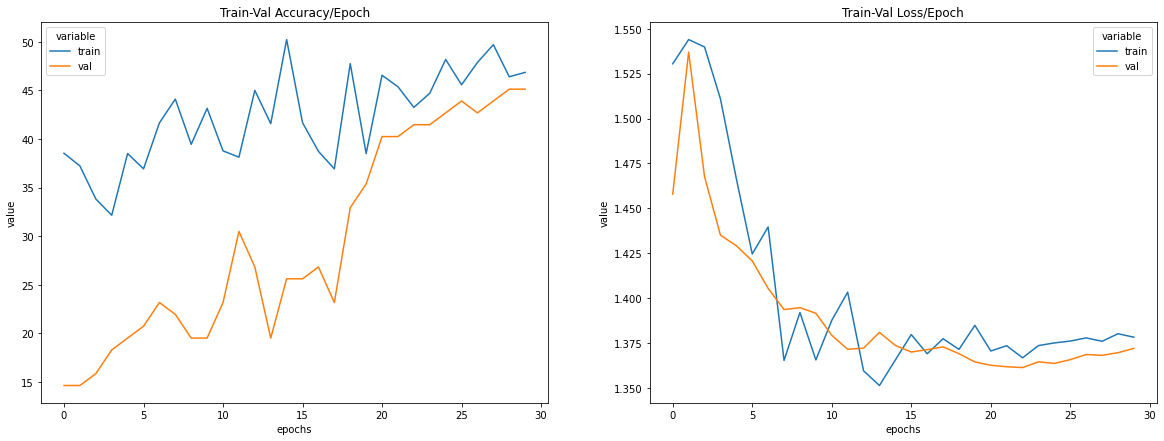

In [2706]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

### Predicting Test Data

In [2187]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [2188]:
print("TEST ACCURACY : ",round(accuracy_score(y_test,y_pred_list),5))

TEST ACCURACY :  0.73


### Visualization

In [2707]:
class_idx = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5}

<AxesSubplot:>

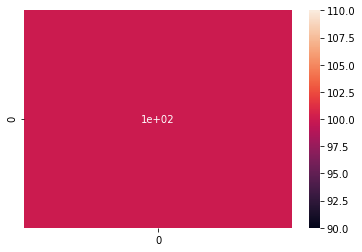

In [2708]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=class_idx, index=class_idx)

sns.heatmap(confusion_matrix_df, annot=True)

In [2709]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# Running all 21 models

In [279]:
def fit_predict(model, optimizer, criterion, train_loader):
    for e in tqdm(range(1, EPOCHS+1)):
    
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_pred_list

In [2652]:
epochs = [20,9,30,30,30,30,15,25,18,18,18,20,20,20,25,20,25,50,33,25,15]
batch = [8,4,8,8,8,15,5,5,4,5,5,5,8,4,5,5,4,8,12,5,5]
LEARNING_RATE = 0.001
NUM_FEATURES = 30
DROPOUT = 0.7
M = 2 # Number of neurons
WEIGHT_DECAY = 0.7
all_y_preds = []
for i in range(21):
    BATCH_SIZE = batch[i]
    EPOCHS = epochs[i]
    # split data
    X_train, X_val, y_train, y_val = train_test_split(dfs_x[i], dfs_y[i], test_size=0.2, stratify=dfs_y[i], random_state=21)
    X_test = dfs_x_test[i]
    y_test = dfs_y_test[i]
    # get top 30 features
    rf = RandomForestClassifier(oob_score=True)
    rf.fit(X_train, y_train)
    imps = rfpimp.importances(rf, X_val, y_val)
    imps['rank'] = imps['Importance'].rank()
    top30 = list(imps.sort_values('rank').iloc[:30].index)
    X_train = X_train[top30]
    X_val = X_val[top30]
    X_test = X_test[top30]
    # normalize
    X_train, X_val, y_train, y_val, X_test, y_test = normalize(X_train, X_val, y_train, y_val, X_test, y_test)
    # get datasets
    train_dataset, val_dataset, test_dataset = get_datasets(X_train, X_val, y_train, y_val, X_test, y_test)
    # over sample
    NUM_CLASSES = len(np.unique(y_train))
    class_weights, weighted_sampler = over_sample(train_dataset, y_train)
    # make dataloader
    train_loader, val_loader, test_loader = make_loaders(train_dataset, val_dataset, test_dataset, weighted_sampler)
    # initialize model with global hyper parameters
    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES,d=DROPOUT,M=M)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay = WEIGHT_DECAY)
    # train and predict on test data
    print(f"working on model {i}")
    y_pred_list = fit_predict(model, optimizer, criterion, train_loader)
    all_y_preds.extend(y_pred_list)

working on model 0


  0%|          | 0/20 [00:00<?, ?it/s]

working on model 1


  0%|          | 0/9 [00:00<?, ?it/s]

working on model 2


  0%|          | 0/30 [00:00<?, ?it/s]

working on model 3


  0%|          | 0/30 [00:00<?, ?it/s]

working on model 4


  0%|          | 0/30 [00:00<?, ?it/s]

working on model 5


  0%|          | 0/30 [00:00<?, ?it/s]

working on model 6


  0%|          | 0/15 [00:00<?, ?it/s]

working on model 7


  0%|          | 0/25 [00:00<?, ?it/s]

working on model 8


  0%|          | 0/18 [00:00<?, ?it/s]

working on model 9


  0%|          | 0/18 [00:00<?, ?it/s]

working on model 10


  0%|          | 0/18 [00:00<?, ?it/s]

working on model 11


  0%|          | 0/20 [00:00<?, ?it/s]

working on model 12


  0%|          | 0/20 [00:00<?, ?it/s]

working on model 13


  0%|          | 0/20 [00:00<?, ?it/s]

working on model 14


  0%|          | 0/25 [00:00<?, ?it/s]

working on model 15


  0%|          | 0/20 [00:00<?, ?it/s]

working on model 16


  0%|          | 0/25 [00:00<?, ?it/s]

working on model 17


  0%|          | 0/50 [00:00<?, ?it/s]

working on model 18


  0%|          | 0/33 [00:00<?, ?it/s]

working on model 19


  0%|          | 0/25 [00:00<?, ?it/s]

working on model 20


  0%|          | 0/15 [00:00<?, ?it/s]

In [2645]:
print("TEST ACCURACY : ",round(accuracy_score(y_test_all,all_y_preds),5))

TEST ACCURACY :  0.53993


### Make Submission

In [2646]:
test['target']=all_y_preds

In [2647]:
submissions = test[['obs_id','target']]

In [2648]:
submissions.to_csv('submissions.csv', index=False)

In [2649]:
! kaggle competitions submit -c ml2-usf-2021 -f submissions.csv -m "3 Layer NN with sampling, BatchNorm and Dropout"

100%|██████████████████████████████████████| 12.9k/12.9k [00:02<00:00, 4.56kB/s]
Successfully submitted to ML2 USF 2021

In [208]:
print ('Submission Date : ' + str(datetime.datetime.today()))

Submission Date : 2021-05-08 22:08:38.338391
